#### IMPORTANDO BIBLIOTECAS

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import GridSearchCV
from math import sqrt

import multiprocessing as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### CARREGANDO DADOS E CRIANDO FEATURES TEMPORAIS

In [2]:
# # df_dados = pd.read_csv('../dados/sinteticos/sales_sint_mensal.csv')
# df_dados = pd.read_csv('../dados/sales25.csv')

# df_dados['date'] =  pd.to_datetime(df_dados['date'],format='%Y-%m-%d',errors='coerce')

# #COMENTAR PARA DADOS SINTÉTICOS
# df_dados = df_dados[df_dados['item_nbr'] == 1439]

# df_dados = df_dados[df_dados['date'] >= '2017-08-01']
# df_dados = df_dados[df_dados['date'] <= '2020-08-30']
# #COMENTAR PARA DADOS SINTÉTICOS

# df_dados['d_semana'] = df_dados['date'].dt.strftime("%u")
# df_dados['d_mes'] = df_dados['date'].dt.strftime("%d")
# df_dados['d_ano'] = df_dados['date'].dt.strftime("%j")

# df_dados['d_semana'] = df_dados['d_semana'].astype(int)
# df_dados['d_mes'] = df_dados['d_mes'].astype(int)
# df_dados['d_ano'] = df_dados['d_ano'].astype(int)

# feature_names = ['unit_sales','price','d_semana','d_mes','d_ano']
# df_dados_model = df_dados.filter(feature_names)

# coluna_serie = 'unit_sales'

# df_dados_model

In [3]:
df_dados = pd.read_csv('../dados/dados_onibus.csv')

df_dados['data_hora'] =  pd.to_datetime(df_dados['data_hora'],format='%Y-%m-%d %H:%M:%S',errors='coerce')

df_dados = df_dados[df_dados['linha'] == 52]

df_dados['d_semana'] = df_dados['data_hora'].dt.strftime("%u")
df_dados['d_mes'] = df_dados['data_hora'].dt.strftime("%d")
df_dados['d_ano'] = df_dados['data_hora'].dt.strftime("%j")

df_dados['d_semana'] = df_dados['d_semana'].astype(int)
df_dados['d_mes'] = df_dados['d_mes'].astype(int)
df_dados['d_ano'] = df_dados['d_ano'].astype(int)

df_dados = df_dados[0:3500]

feature_names = ['validations_per_hour','hora','d_semana','d_mes','d_ano']
df_dados_model = df_dados.filter(feature_names)

coluna_serie = 'validations_per_hour'

df_dados

,linha,data_hora,validations_per_hour,d_semana,hour_sin,hour_cos,hora,d_mes,d_ano,mes,semana_do_mes,domingo,segunda,terca,quarta,quinta,sexta,sabado,feriado,vespera_feriado
154132,52,2018-01-01 03:00:00,42,1,7.308360e-01,0.682553,3,1,1,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
154133,52,2018-01-01 04:00:00,83,1,8.878852e-01,0.460065,4,1,1,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
154134,52,2018-01-01 05:00:00,424,1,9.790841e-01,0.203456,5,1,1,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
154135,52,2018-01-01 06:00:00,771,1,9.976688e-01,-0.068242,6,1,1,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
154136,52,2018-01-01 07:00:00,938,1,9.422609e-01,-0.334880,7,1,1,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157627,52,2018-06-15 23:00:00,243,5,-2.449294e-16,1.000000,23,15,166,6,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0
157628,52,2018-06-16 00:00:00,134,6,0.000000e+00,1.000000,0,16,167,6,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0
157629,52,2018-06-16 04:00:00,107,6,8.878852e-01,0.460065,4,16,167,6,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0
157630,52,2018-06-16 05:00:00,383,6,9.790841e-01,0.203456,5,16,167,6,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0


In [4]:
df_dados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3500 entries, 154132 to 157631
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   linha                 3500 non-null   int64         
 1   data_hora             3500 non-null   datetime64[ns]
 2   validations_per_hour  3500 non-null   int64         
 3   d_semana              3500 non-null   int64         
 4   hour_sin              3500 non-null   float64       
 5   hour_cos              3500 non-null   float64       
 6   hora                  3500 non-null   int64         
 7   d_mes                 3500 non-null   int64         
 8   d_ano                 3500 non-null   int64         
 9   mes                   3500 non-null   int64         
 10  semana_do_mes         3500 non-null   int64         
 11  domingo               3500 non-null   float64       
 12  segunda               3500 non-null   float64       
 13  terca           

#### VISUALIZANDO DADOS

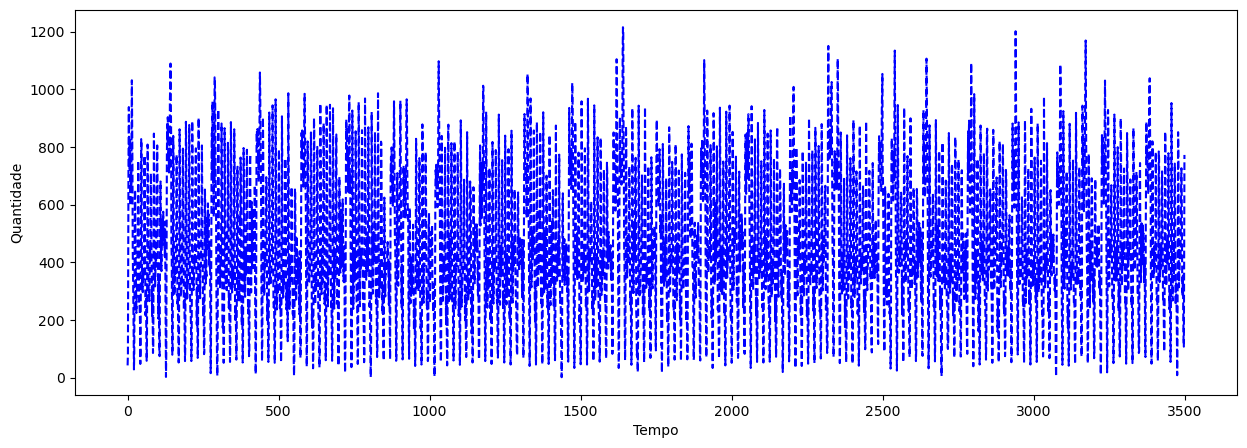

In [5]:
df_dados_visualizacao = df_dados_model#.iloc[0:300]

plt.figure(figsize=(15,5))
plt.plot(range(len(df_dados_visualizacao[coluna_serie])),df_dados_visualizacao[coluna_serie], 'b--')
# plt.xlim(200,230)
plt.xlabel('Tempo')
plt.ylabel('Quantidade')
plt.show()

In [6]:
if(coluna_serie == 'unit_sales'):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(df_dados_visualizacao)),df_dados_visualizacao['price'], 'r--')
    # plt.xlim(200,230)
    plt.show()

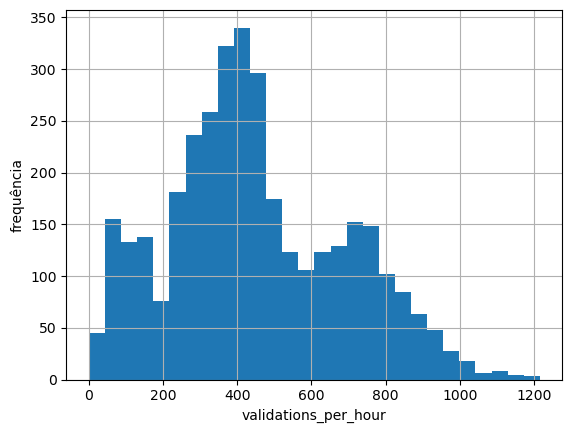

In [7]:
df_dados_visualizacao[coluna_serie].hist(bins='auto')
plt.xlabel(coluna_serie)
plt.ylabel('frequência')
plt.show()

In [8]:
if(coluna_serie == 'unit_sales'):
    df_dados_visualizacao['price'].hist(bins='auto')
    plt.xlabel('price')
    plt.ylabel('frequência')
    plt.show()

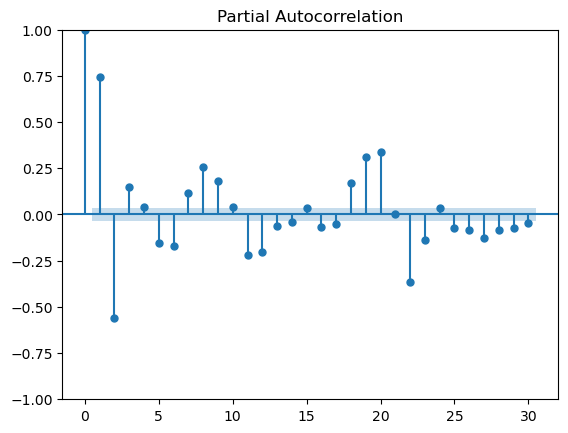

In [9]:
plot_pacf(df_dados_visualizacao[coluna_serie], lags=30, method='ywm')
plt.show()

#### MODELANDO COMO UM PROBLEMA DE SÉRIE TEMPORAL

In [10]:
time_steps = 24  #TAMANHO DA JANELA
test_size = 168  #HORIZONTE DE PREVISÃO

train_size = int(len(df_dados_model)-(test_size))
train, test = df_dados_model.iloc[0:train_size], df_dados_model.iloc[(train_size-time_steps):len(df_dados_model)]
print(len(train), len(test))

3332 192


In [11]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps),0].to_numpy()
        # v = np.append(v,X.iloc[i + time_steps,1])#price
        v = np.append(v,X.iloc[i + time_steps,2])#d_semana
        v = np.append(v,X.iloc[i + time_steps,3])#d_mes
        v = np.append(v,X.iloc[i + time_steps,4])#d_ano
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(train, train[coluna_serie], time_steps)
X_test, y_test = create_dataset(test, test[coluna_serie], time_steps)

print(len(X_train), len(X_test))

# X_train[0]

3308 168


#### CRIANDO E TREINANDO UM MODELO

In [12]:
def getModel():
    
    # return LinearRegression()
    # return DecisionTreeRegressor()
    return RandomForestRegressor(n_jobs=mp.cpu_count())
    # return GradientBoostingRegressor()
 #    parameters = {'bootstrap': [True, False],
 # 'max_depth': [10, 30, 50, 70, 90, 100, None],
 # 'max_features': [None, 'sqrt'],
 # 'min_samples_leaf': [1, 2, 4],
 # 'min_samples_split': [2, 5, 10],
 # 'n_estimators': [200, 400, 600]}
 #    return GridSearchCV(RandomForestRegressor(n_jobs=mp.cpu_count()), parameters)

In [13]:
model = getModel().fit(X_train,y_train)

In [14]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 20,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

#### VALIDANDO O MODELO

In [15]:
preds = []

base_teste = np.copy(X_test)

for i in range(len(base_teste)):
    y_pred = model.predict(np.array([base_teste[i]]))[0]

    preds.append(y_pred)
    
    for k in range(len(preds)):
        
        if i<len(base_teste):
            if k < time_steps:
                if(i<len(base_teste)-1):
                    base_teste[i+1][(time_steps-1)-k] = preds[(len(preds)-1)-k]

len(preds)

168

In [16]:
dados_real = df_dados_model.iloc[(train_size):len(df_dados_model),0].to_numpy()

len(dados_real)

df_real_predito = pd.DataFrame({'real':dados_real,'predito':preds})

df_real_predito

,real,predito
0,458,447.53
1,385,361.04
2,373,325.51
3,396,411.10
4,401,449.49
...,...,...
163,243,64.11
164,134,95.77
165,107,408.13
166,383,722.73


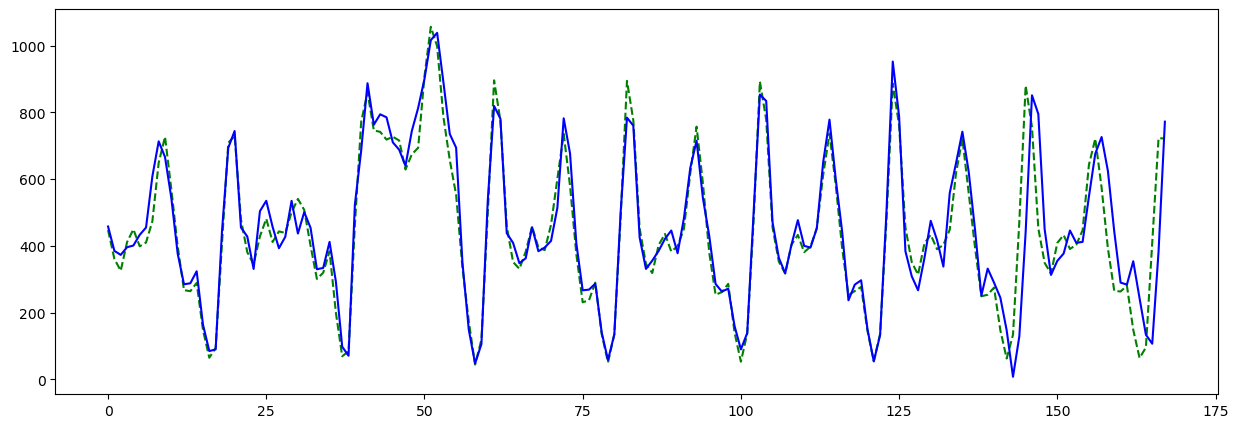

In [17]:
plt.figure(figsize=(15,5))
# plt.plot(range(len(y_train)),y_train, 'g--')
plt.plot(range(len(df_real_predito['predito'])),df_real_predito['predito'], 'g--')
plt.plot(range(len(df_real_predito['real'])),df_real_predito['real'], 'b')
# plt.xlim(0,30)
plt.show()

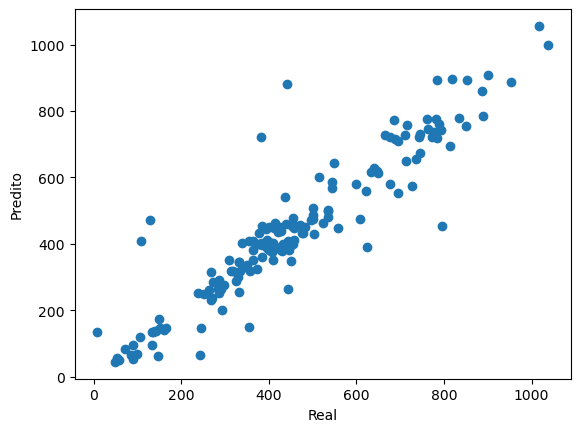

rmse= 84.12588124494208
mae= 14.34583233605341
smape= 51.582142857142856
r2= 0.8563972856721825


In [18]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

plt.scatter(df_real_predito['real'],df_real_predito['predito'])

plt.xlabel('Real')
plt.ylabel('Predito')

plt.show()
print('rmse=',sqrt(mean_squared_error(df_real_predito['real'].array,df_real_predito['predito'].array)))
print('mae=',smape(df_real_predito['real'].array,df_real_predito['predito'].array))
print('smape=',mean_absolute_error(df_real_predito['real'].array,df_real_predito['predito'].array))
print('r2=',r2_score(df_real_predito['real'].array,df_real_predito['predito'].array))